In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

In [3]:
import glob
import geopandas as gpd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import optuna

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(33) # Seed 고정

In [5]:
# 각 gpkg 파일은 분리되어 있는것 같다. 합쳐주기 위해서 folder path를 받아오자
old_f_path = r'/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역'
jaywalk_f_path = r'/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역'
ice_f_path = r'/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/8. 결빙사고 다발지역'
truck_f_path = r'/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/9. 화물차사고 다발지역'
walker_f_path = r'/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/11. 보행자사고 다발지역'

# 각 folder path 내에서 gpkg 확장자 파일의 이름을 추출해서 list로 만들자
old_fnames = glob.glob(f'{old_f_path}/*.gpkg')
jaywalk_fnames = glob.glob(f'{jaywalk_f_path}/*.gpkg')
ice_fnames = glob.glob(f'{ice_f_path}/*.gpkg')
truck_fnames = glob.glob(f'{truck_f_path}/*.gpkg')
walker_fnames = glob.glob(f'{walker_f_path}/*.gpkg')

# fnames 변수의 list를 만들자
fname_list = [old_fnames, jaywalk_fnames, ice_fnames, truck_fnames, walker_fnames]


In [6]:
for name in fname_list:
    print(len(name), '|', name)

3 | ['/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_300.gpkg', '/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_100.gpkg', '/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_500.gpkg']
3 | ['/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역/보행자무단횡단사고 다발지역_100.gpkg', '/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역/보행자무단횡단사고 다발지역_500.gpkg', '/content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역/보행자무단횡단사고 다발지역_300.gpkg']
3 | ['/content/drive/MyDrive/교토

In [16]:
# gdf_merge 함수 선언
# 기능 : filenames 경로의 gpkg 파일을 받아서 geopandas 형식의 dataframe으로 read하고 분리된 파일을 병합하는 함수
# input - filenames : mesge하려는 gpkg 파일 경로를 item으로 하는 list
# output - merged_df(병합된 df), gdfs (df의 각각 list ~ 선택)

def gpd_merge(file_names):

    gdfs = []

    # Load each GeoPackage file in the list
    for file_name in file_names:
        try:
            gdf = gpd.read_file(file_name, encoding='cp949')

            gdf = gdf.dropna()

            gdfs.append(gdf)

            print(f"Loaded GeoPackage file: {file_name}")
            print(f"Number of rows after removing missing values: {len(gdf)}")
        except Exception as e:
            print(f"Error loading file {file_name}: {e}")

    # 좌표계 변환 : EPSG:5179 -> EPSG:4326
    merged_gdf = pd.concat(gdfs, axis=0)
    merged_gdf.geometry = merged_gdf.geometry.to_crs('EPSG:4326')

    # geometry 열로부터 위도, 경도 열을 추가함 (multipoligon의 center?)
    merged_gdf['위도'] = merged_gdf['geometry'].apply(lambda geom: geom.centroid.y if geom.geom_type == 'Point' else geom.centroid.y)
    merged_gdf['경도'] = merged_gdf['geometry'].apply(lambda geom: geom.centroid.x if geom.geom_type == 'Point' else geom.centroid.x)

    return merged_gdf

In [17]:
old_df     = gpd_merge(old_fnames)
jaywalk_df = gpd_merge(jaywalk_fnames)
ice_df     = gpd_merge(ice_fnames)
truck_df   = gpd_merge(truck_fnames)
walker_df  = gpd_merge(walker_fnames)

Loaded GeoPackage file: /content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_500.gpkg
Number of rows after removing missing values: 14
Loaded GeoPackage file: /content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_300.gpkg
Number of rows after removing missing values: 23
Loaded GeoPackage file: /content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/2. 보행노인사고 다발지역/보행노인사고 다발지역_100.gpkg
Number of rows after removing missing values: 64
Loaded GeoPackage file: /content/drive/MyDrive/교통사고/open/open/external_open/대구 빅데이터 마트 데이터/7. 안전/5. 보행자무단횡단사고 다발지역/보행자무단횡단사고 다발지역_500.gpkg
Number of rows after removing missing values: 48
Loaded GeoPackage file: /content/drive/MyDrive/교통사고/open/open/external_ope

In [18]:
old_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# 전처리한 파일 저장하기
old_df.to_csv(os.path.join(old_f_path, "보행노인사고.csv"), encoding='cp949', index=False)
jaywalk_df.to_csv(os.path.join(jaywalk_f_path, "무단횡단사고.csv"), encoding='cp949', index=False)
ice_df.to_csv(os.path.join(ice_f_path, "결빙사고.csv"), encoding='cp949', index=False)
truck_df.to_csv(os.path.join(truck_f_path, "화물차사고.csv"), encoding='cp949', index=False)
walker_df.to_csv(os.path.join(walker_f_path, "보행자사고.csv"), encoding='cp949', index=False)

In [61]:
# 불러오기
old_df = pd.read_csv(os.path.join(old_f_path, "보행노인사고.csv"), encoding='cp949')
jaywalk_df = pd.read_csv(os.path.join(jaywalk_f_path, "무단횡단사고.csv"), encoding='cp949')
ice_df = pd.read_csv(os.path.join(ice_f_path, "결빙사고.csv"), encoding='cp949')
truck_df = pd.read_csv(os.path.join(truck_f_path, "화물차사고.csv"), encoding='cp949')
walker_df = pd.read_csv(os.path.join(walker_f_path, "보행자사고.csv"), encoding='cp949')

In [62]:
gdf_list = [old_df, jaywalk_df, ice_df, truck_df, walker_df]
# 열이름이 동일하다 (다발지역내 사고 / 사상자 / 사망자 / 중상자 / 경상자 / 부상자 / 경상자 / 부상신고자수 합계 및 평균을 의미), TAAS API의 설명 참조
# occrrnc_cnt : 사고건수 / caslt_cnt : 사상자수 / dth_dnv_cnt : 사망자수 / se_dnv_cnt : 중상자수 / sl_dnv_cnt : 경상자수 / wnd_dnv_cnt : 부상신고자수
#

for gdf in gdf_list:
    print(len(gdf), gdf.columns.to_list())

101 ['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum', 'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean', 'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum', 'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry', '위도', '경도']
509 ['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum', 'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean', 'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum', 'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry', '위도', '경도']
44 ['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum', 'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean', 'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum', 'sl_dnv_cnt_mean', 'wnd_dnv_cnt_sum', 'wnd_dnv_cnt_mean', 'geometry', '위도', '경도']
315 ['id', 'count', 'occrrnc_cnt_sum', 'occrrnc_cnt_mean', 'caslt_cnt_sum', 'caslt_cnt_mean', 'dth_dnv_cnt_sum', 'dth_dnv_cnt_mean', 'se_dnv_cnt_sum', 'se_dnv_cnt_mean', 'sl_dnv_cnt_sum', 'sl

In [63]:
light_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구보안등정보.csv', encoding='cp949')[['설치개수', '소재지지번주소','위도','경도']]
light_df = light_df.rename(columns={'설치개수': '보안등 설치개수'})


child_area_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구어린이보호구역정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소', 'CCTV설치대수','위도','경도']]
# 어린이 보호구역을 의미
child_area_df['보호구역'] = 1



parking_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구주차장정보.csv', encoding='cp949')[['소재지지번주소', '급지구분','위도','경도']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])



cctv_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구CCTV정보.csv', encoding='cp949')[['소재지지번주소', '단속구분','위도','경도']]
cctv_df = pd.get_dummies(cctv_df, columns=['단속구분'])


In [64]:
df_dict = {'보안등':light_df, '어린이보호구역':child_area_df, '주차장':parking_df, 'cctv':cctv_df}

In [65]:
train_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/train.csv')
test_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/sample_submission.csv')

In [66]:
train_df = train_org.copy()
test_df = test_org.copy()

In [67]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [68]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 test_df 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df = test_df.drop(columns=['시군구'])

In [69]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [70]:
# train_df 기준으로 인코딩 unique 값의 list를 만들자
gu_list = train_df['구'].unique().tolist()
print(gu_list)

['중구', '달서구', '수성구', '북구', '동구', '서구', '달성군', '남구']


In [71]:
# df와 unique list(A:구)를 입력해서 '구' 값을 추출해서 열을 새로 만드는 전처리 함수
def preprocess_df(df, A):
    # 1) Create a new column '구' to store the values
    df['구'] = np.nan

    # 2) Iterate through each row in the data frame
    for index, row in df.iterrows():
        # Check if the value in '소재지지번주소' is not NaN
        if not pd.isna(row['소재지지번주소']):
            # Check if any value in A is present in the '소재지지번주소' column
            for value in A:
                if value in row['소재지지번주소']:
                    # If found, store the value in column '구'
                    df.at[index, '구'] = value
                    break  # Break the loop if a match is found

    return df


In [72]:
for key, df in df_dict.items():
    print(key, '|열 개수:',  len(df.columns), '|열 이름:', df.columns.tolist())

보안등 |열 개수: 4 |열 이름: ['보안등 설치개수', '소재지지번주소', '위도', '경도']
어린이보호구역 |열 개수: 5 |열 이름: ['소재지지번주소', 'CCTV설치대수', '위도', '경도', '보호구역']
주차장 |열 개수: 6 |열 이름: ['소재지지번주소', '위도', '경도', '급지구분_1', '급지구분_2', '급지구분_3']
cctv |열 개수: 7 |열 이름: ['소재지지번주소', '위도', '경도', '단속구분_1', '단속구분_2', '단속구분_4', '단속구분_99']


In [73]:
for key, df in df_dict.items():
     df = preprocess_df(df, gu_list)

In [74]:
for key, df in df_dict.items():
    print(key, '|열 개수:',  len(df.columns), '|열 이름:', df.columns.tolist())

보안등 |열 개수: 5 |열 이름: ['보안등 설치개수', '소재지지번주소', '위도', '경도', '구']
어린이보호구역 |열 개수: 6 |열 이름: ['소재지지번주소', 'CCTV설치대수', '위도', '경도', '보호구역', '구']
주차장 |열 개수: 7 |열 이름: ['소재지지번주소', '위도', '경도', '급지구분_1', '급지구분_2', '급지구분_3', '구']
cctv |열 개수: 8 |열 이름: ['소재지지번주소', '위도', '경도', '단속구분_1', '단속구분_2', '단속구분_4', '단속구분_99', '구']


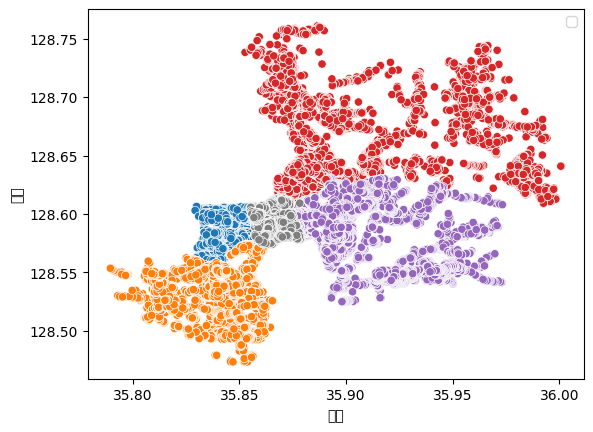

In [75]:
# 위도, 경도에 따른 구의 분포를 확인해보자
sns.scatterplot(x='위도', y='경도', hue='구', data=light_df)
plt.legend("")

In [76]:
# gu_model을 만들 df를 합쳐주자
gu_df = pd.concat(df_dict.values(), axis=0)[['위도', '경도', '구']]

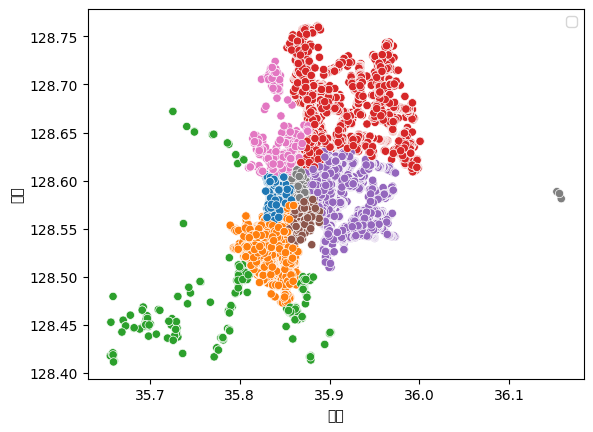

In [77]:
# 위도, 경도에 따른 구의 분포를 확인해보자
sns.scatterplot(x='위도', y='경도', hue='구', data=gu_df)
plt.legend("")

In [78]:
# 일단 단순한 RF모델/KNN 사용해보자 :

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


gu_df = gu_df.dropna()
X = gu_df[['위도', '경도']]
y = gu_df['구']
print(len(X), len(y))

kf = StratifiedKFold(n_splits=5, shuffle=True)

rf_classifier = RandomForestClassifier()
knn_classifier = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

classifiers = [rf_classifier, knn_classifier]
classifier_names = ['Random Forest', 'k-Nearest Neighbors (KNN)']

for clf, clf_name in zip(classifiers, classifier_names):
    # Perform k-fold cross-validation and calculate accuracy
    accuracy_scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')

    # Print results
    print(f'{clf_name} Model:')
    print(f'Accuracy Scores: {accuracy_scores}')
    print(f'Mean Accuracy: {accuracy_scores.mean():.2%}\n')

45698 45698
Random Forest Model:
Accuracy Scores: [0.99846827 0.99792123 0.99857768 0.99813984 0.99835868]
Mean Accuracy: 99.83%

k-Nearest Neighbors (KNN) Model:
Accuracy Scores: [0.99868709 0.99857768 0.99846827 0.99781158 0.99835868]
Mean Accuracy: 99.84%



In [79]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [80]:
# 저장 및 불러오기
from joblib import dump, load
model_filename = 'gu_model_KNN.joblib'
dump(knn_classifier, model_filename)

gu_model = load(model_filename)

In [81]:
# gu model로 gpd에서 '구'를 예측하자
for gdf in gdf_list:
    gdf['구'] = gu_model.predict(gdf[['위도', '경도']])

    # 사용안할 열을 drop
    cols_remove = ['geometry', 'occrrnc_cnt_mean', 'caslt_cnt_mean', 'dth_dnv_cnt_mean', 'se_dnv_cnt_mean', 'sl_dnv_cnt_mean', 'wnd_dnv_cnt_mean', '위도', '경도', 'id']

    if all(column in gdf.columns for column in cols_remove):
        gdf.drop(cols_remove, axis=1, inplace=True)
    # gdf.reset_index(drop=True, inplace=True)

In [82]:
# 각 df로부터 구 기준으로 집계된 새로운 df들을 만들자 (agg_dfs에 저장)
def create_agg_df(dataframes):

    aggregated_dfs = []

    for df in dataframes:
        # Perform groupby operation and aggregate based on the specified column
        aggregated_df = df.groupby('구').sum().reset_index()
        aggregated_dfs.append(aggregated_df)

    return aggregated_dfs

# Example: Create aggregated data frames based on the 'old' column
agg_dfs = create_agg_df(gdf_list)

In [83]:
# train 데이터와 합쳐주기 위해서 각 집계된 리스트의 열이름을 구별해서 합쳐주자
string_list = ['old', 'jay', 'ice', 'truck', 'walker']

# Iterate over each data frame in the list and modify column names
for i, (agg_df, prefix) in enumerate(zip(agg_dfs, string_list)):
    if prefix != '구':
        # Modify column names based on the rules
        new_column_names = [prefix + '_' + col if col != '구' else col for col in agg_df.columns]
        agg_df.columns = new_column_names

In [84]:
for df in agg_dfs:
    print(df.columns.to_list() )
    # print(len(df), len(df['구'].unique()))

['구', 'old_count', 'old_occrrnc_cnt_sum', 'old_caslt_cnt_sum', 'old_dth_dnv_cnt_sum', 'old_se_dnv_cnt_sum', 'old_sl_dnv_cnt_sum', 'old_wnd_dnv_cnt_sum']
['구', 'jay_count', 'jay_occrrnc_cnt_sum', 'jay_caslt_cnt_sum', 'jay_dth_dnv_cnt_sum', 'jay_se_dnv_cnt_sum', 'jay_sl_dnv_cnt_sum', 'jay_wnd_dnv_cnt_sum']
['구', 'ice_count', 'ice_occrrnc_cnt_sum', 'ice_caslt_cnt_sum', 'ice_dth_dnv_cnt_sum', 'ice_se_dnv_cnt_sum', 'ice_sl_dnv_cnt_sum', 'ice_wnd_dnv_cnt_sum']
['구', 'truck_count', 'truck_occrrnc_cnt_sum', 'truck_caslt_cnt_sum', 'truck_dth_dnv_cnt_sum', 'truck_se_dnv_cnt_sum', 'truck_sl_dnv_cnt_sum', 'truck_wnd_dnv_cnt_sum']
['구', 'walker_count', 'walker_occrrnc_cnt_sum', 'walker_caslt_cnt_sum', 'walker_dth_dnv_cnt_sum', 'walker_se_dnv_cnt_sum', 'walker_sl_dnv_cnt_sum', 'walker_wnd_dnv_cnt_sum']


In [85]:
# '구'를 기준으로 merge 하자

from functools import reduce

agg_merged_df = reduce(lambda left, right: pd.merge(left, right, on='구', how='outer'), agg_dfs)
agg_merged_df = agg_merged_df.fillna(0)
print(agg_merged_df.shape, agg_merged_df.columns.to_list())

(8, 36) ['구', 'old_count', 'old_occrrnc_cnt_sum', 'old_caslt_cnt_sum', 'old_dth_dnv_cnt_sum', 'old_se_dnv_cnt_sum', 'old_sl_dnv_cnt_sum', 'old_wnd_dnv_cnt_sum', 'jay_count', 'jay_occrrnc_cnt_sum', 'jay_caslt_cnt_sum', 'jay_dth_dnv_cnt_sum', 'jay_se_dnv_cnt_sum', 'jay_sl_dnv_cnt_sum', 'jay_wnd_dnv_cnt_sum', 'ice_count', 'ice_occrrnc_cnt_sum', 'ice_caslt_cnt_sum', 'ice_dth_dnv_cnt_sum', 'ice_se_dnv_cnt_sum', 'ice_sl_dnv_cnt_sum', 'ice_wnd_dnv_cnt_sum', 'truck_count', 'truck_occrrnc_cnt_sum', 'truck_caslt_cnt_sum', 'truck_dth_dnv_cnt_sum', 'truck_se_dnv_cnt_sum', 'truck_sl_dnv_cnt_sum', 'truck_wnd_dnv_cnt_sum', 'walker_count', 'walker_occrrnc_cnt_sum', 'walker_caslt_cnt_sum', 'walker_dth_dnv_cnt_sum', 'walker_se_dnv_cnt_sum', 'walker_sl_dnv_cnt_sum', 'walker_wnd_dnv_cnt_sum']


In [86]:
train_df = pd.merge(train_df, agg_merged_df, on='구', how='left')
test_df = pd.merge(test_df, agg_merged_df, on='구', how='left')
print(train_df.shape, test_df.shape)

(39609, 62) (10963, 47)


In [89]:
agg_sec_df = light_df[['구', '보안등 설치개수']].groupby(['구']).sum().reset_index()
agg_sec_df.columns = ['구', '보안등_수']
agg_sec_df.head()

,구,보안등_수
0,남구,7357
1,달서구,10083
2,달성군,7372
3,동구,11926
4,북구,9257


In [90]:
agg_child_df = child_area_df[['구', 'CCTV설치대수', '보호구역']].groupby('구').sum().reset_index()
agg_child_df.columns = ['구', '어린이_CCTV_설치대수', '어린이보호구역_수']
agg_child_df.head()

,구,어린이_CCTV_설치대수,어린이보호구역_수
0,남구,162.0,40
1,달성군,15.0,99
2,북구,399.0,122
3,서구,0.0,56
4,수성구,0.0,118


In [91]:
agg_parking_df = parking_df[['구', '급지구분_1','급지구분_2','급지구분_3']].groupby('구').sum().reset_index()
agg_parking_df.columns = ['구', '급지1','급지2','급지3']
agg_parking_df.head()

,구,급지1,급지2,급지3
0,남구,32,4,0
1,달서구,0,28,54
2,달성군,0,0,64
3,동구,7,1,18
4,북구,65,129,63


In [92]:
agg_cctv_df = cctv_df[['구', '단속구분_1','단속구분_2','단속구분_4','단속구분_99']].groupby('구').sum().reset_index()
agg_cctv_df.columns = ['구', '단속1','단속2','단속3','단속99']
agg_cctv_df.head()

,구,단속1,단속2,단속3,단속99
0,남구,9,32,54,0
1,달서구,27,114,131,6
2,달성군,66,134,0,20
3,동구,19,60,0,14
4,북구,37,85,0,2


In [93]:
agg_csv_dfs = [agg_sec_df, agg_child_df, agg_parking_df, agg_cctv_df]

agg_csv_df = reduce(lambda left, right: pd.merge(left, right, on='구', how='outer'), agg_csv_dfs)
agg_csv_df = agg_csv_df.fillna(0)
print(agg_csv_df.shape, len(agg_csv_df['구'].unique()), agg_csv_df.columns.to_list())

(8, 11) 8 ['구', '보안등_수', '어린이_CCTV_설치대수', '어린이보호구역_수', '급지1', '급지2', '급지3', '단속1', '단속2', '단속3', '단속99']


In [94]:
train_df = pd.merge(train_df, agg_csv_df, on='구', how='left').fillna(0)
test_df = pd.merge(test_df, agg_csv_df, on='구', how='left').fillna(0)
print(train_df.shape, test_df.shape)

(39609, 72) (10963, 57)


In [98]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [99]:
train_x.isna().sum()

사고일시                      0
요일                        0
기상상태                      0
노면상태                      0
사고유형                      0
도시                        0
구                         0
동                         0
사고발생횟수                    0
도로형태1                     0
도로형태2                     0
old_count                 0
old_occrrnc_cnt_sum       0
old_caslt_cnt_sum         0
old_dth_dnv_cnt_sum       0
old_se_dnv_cnt_sum        0
old_sl_dnv_cnt_sum        0
old_wnd_dnv_cnt_sum       0
jay_count                 0
jay_occrrnc_cnt_sum       0
jay_caslt_cnt_sum         0
jay_dth_dnv_cnt_sum       0
jay_se_dnv_cnt_sum        0
jay_sl_dnv_cnt_sum        0
jay_wnd_dnv_cnt_sum       0
ice_count                 0
ice_occrrnc_cnt_sum       0
ice_caslt_cnt_sum         0
ice_dth_dnv_cnt_sum       0
ice_se_dnv_cnt_sum        0
ice_sl_dnv_cnt_sum        0
ice_wnd_dnv_cnt_sum       0
truck_count               0
truck_occrrnc_cnt_sum     0
truck_caslt_cnt_sum       0
truck_dth_dnv_cnt_su

In [100]:
test_x.isna().sum()

사고일시                      0
요일                        0
기상상태                      0
노면상태                      0
사고유형                      0
도시                        0
구                         0
동                         0
사고발생횟수                    0
도로형태1                     0
도로형태2                     0
old_count                 0
old_occrrnc_cnt_sum       0
old_caslt_cnt_sum         0
old_dth_dnv_cnt_sum       0
old_se_dnv_cnt_sum        0
old_sl_dnv_cnt_sum        0
old_wnd_dnv_cnt_sum       0
jay_count                 0
jay_occrrnc_cnt_sum       0
jay_caslt_cnt_sum         0
jay_dth_dnv_cnt_sum       0
jay_se_dnv_cnt_sum        0
jay_sl_dnv_cnt_sum        0
jay_wnd_dnv_cnt_sum       0
ice_count                 0
ice_occrrnc_cnt_sum       0
ice_caslt_cnt_sum         0
ice_dth_dnv_cnt_sum       0
ice_se_dnv_cnt_sum        0
ice_sl_dnv_cnt_sum        0
ice_wnd_dnv_cnt_sum       0
truck_count               0
truck_occrrnc_cnt_sum     0
truck_caslt_cnt_sum       0
truck_dth_dnv_cnt_su

In [101]:
# '사고일시' 열을 datetime 형식으로 변환
train_x['사고일시'] = pd.to_datetime(train_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
train_x['year'] = train_x['사고일시'].dt.year
train_x['month'] = train_x['사고일시'].dt.month
train_x['day'] = train_x['사고일시'].dt.day
train_x['hour'] = train_x['사고일시'].dt.hour
train_x['day_of_week'] = train_x['사고일시'].dt.dayofweek

In [102]:
# '사고일시' 열을 datetime 형식으로 변환
test_x['사고일시'] = pd.to_datetime(test_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test_x['year'] = test_x['사고일시'].dt.year
test_x['month'] = test_x['사고일시'].dt.month
test_x['day'] = test_x['사고일시'].dt.day
test_x['hour'] = test_x['사고일시'].dt.hour
test_x['day_of_week'] = test_x['사고일시'].dt.dayofweek

In [105]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']
# 공휴일 변수생성
train_x['holiday'] = np.where((train_x.day_of_week >= 5) | (train_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test_x['holiday'] = np.where((test_x.day_of_week >= 5) | (test_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [106]:
# '사고일시' 열 삭제
train_x.drop(columns=['사고일시'], inplace=True)
# '사고일시' 열 삭제
test_x.drop(columns=['사고일시'], inplace=True)

In [107]:
# 계절 변수 생성
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']
train_x['season'] = group_season(train_x)
test_x['season'] = group_season(test_x)

In [109]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 838.4 kB/s eta 0:00:00


In [110]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2', 'season']

,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,old_count,old_occrrnc_cnt_sum,old_caslt_cnt_sum,old_dth_dnv_cnt_sum,old_se_dnv_cnt_sum,old_sl_dnv_cnt_sum,old_wnd_dnv_cnt_sum,jay_count,jay_occrrnc_cnt_sum,jay_caslt_cnt_sum,jay_dth_dnv_cnt_sum,jay_se_dnv_cnt_sum,jay_sl_dnv_cnt_sum,jay_wnd_dnv_cnt_sum,ice_count,ice_occrrnc_cnt_sum,ice_caslt_cnt_sum,ice_dth_dnv_cnt_sum,ice_se_dnv_cnt_sum,ice_sl_dnv_cnt_sum,ice_wnd_dnv_cnt_sum,truck_count,truck_occrrnc_cnt_sum,truck_caslt_cnt_sum,truck_dth_dnv_cnt_sum,truck_se_dnv_cnt_sum,truck_sl_dnv_cnt_sum,truck_wnd_dnv_cnt_sum,walker_count,walker_occrrnc_cnt_sum,walker_caslt_cnt_sum,walker_dth_dnv_cnt_sum,walker_se_dnv_cnt_sum,walker_sl_dnv_cnt_sum,walker_wnd_dnv_cnt_sum,보안등_수,어린이_CCTV_설치대수,어린이보호구역_수,급지1,급지2,급지3,단속1,단속2,단속3,단속99,year,month,day,hour,day_of_week,holiday,season
0,4.627926,4.712888,4.712878,3.817650,4.726704,4.541610,4.282449,131,4.671841,4.599599,11.0,65.0,76.0,20.0,45.0,1.0,10.0,39.0,195.0,273.0,39.0,78.0,78.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,19.0,31.0,3.0,16.0,12.0,0.0,44.0,176.0,322.0,7.0,169.0,120.0,26.0,5468,148.0,21.0,175,0,0,5,24,46,0,2019,1,1,0,1,1,4.659111
1,4.627926,4.779150,4.712878,3.817650,4.726704,4.618441,4.738938,678,4.671841,4.599599,9.0,45.0,59.0,0.0,50.0,9.0,0.0,108.0,535.0,572.0,38.0,361.0,103.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,376.0,593.0,20.0,404.0,160.0,9.0,147.0,639.0,936.0,27.0,685.0,224.0,0.0,10083,0.0,0.0,0,28,54,27,114,131,6,2019,1,1,0,1,1,4.659111
2,4.627926,4.712888,4.712878,3.817650,4.726704,4.727300,4.842715,604,4.671841,4.599599,14.0,70.0,70.0,0.0,70.0,0.0,0.0,47.0,144.0,147.0,44.0,50.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,96.0,144.0,0.0,120.0,24.0,0.0,41.0,164.0,271.0,6.0,180.0,72.0,13.0,11911,0.0,118.0,3,11,11,25,69,0,7,2019,1,1,1,1,1,4.659111
3,4.627926,4.712888,4.712878,4.944597,4.726704,4.687669,4.208920,426,4.671841,4.599599,38.0,235.0,250.0,0.0,235.0,15.0,0.0,157.0,628.0,666.0,73.0,279.0,279.0,35.0,23.0,69.0,92.0,0.0,46.0,46.0,0.0,129.0,524.0,892.0,21.0,602.0,259.0,10.0,116.0,485.0,672.0,2.0,483.0,137.0,50.0,9257,399.0,122.0,65,129,63,37,85,0,2,2019,1,1,2,1,1,4.659111
4,4.627926,4.712888,4.712878,4.944597,4.726704,4.889534,4.549091,825,4.671841,4.599599,7.0,35.0,35.0,0.0,35.0,0.0,0.0,36.0,144.0,180.0,0.0,72.0,72.0,36.0,21.0,63.0,105.0,0.0,42.0,63.0,0.0,24.0,99.0,132.0,11.0,102.0,19.0,0.0,29.0,116.0,174.0,0.0,116.0,58.0,0.0,11926,0.0,0.0,7,1,18,19,60,0,14,2019,1,1,4,1,1,4.659111


,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,old_count,old_occrrnc_cnt_sum,old_caslt_cnt_sum,old_dth_dnv_cnt_sum,old_se_dnv_cnt_sum,old_sl_dnv_cnt_sum,old_wnd_dnv_cnt_sum,jay_count,jay_occrrnc_cnt_sum,jay_caslt_cnt_sum,jay_dth_dnv_cnt_sum,jay_se_dnv_cnt_sum,jay_sl_dnv_cnt_sum,jay_wnd_dnv_cnt_sum,ice_count,ice_occrrnc_cnt_sum,ice_caslt_cnt_sum,ice_dth_dnv_cnt_sum,ice_se_dnv_cnt_sum,ice_sl_dnv_cnt_sum,ice_wnd_dnv_cnt_sum,truck_count,truck_occrrnc_cnt_sum,truck_caslt_cnt_sum,truck_dth_dnv_cnt_sum,truck_se_dnv_cnt_sum,truck_sl_dnv_cnt_sum,truck_wnd_dnv_cnt_sum,walker_count,walker_occrrnc_cnt_sum,walker_caslt_cnt_sum,walker_dth_dnv_cnt_sum,walker_se_dnv_cnt_sum,walker_sl_dnv_cnt_sum,walker_wnd_dnv_cnt_sum,보안등_수,어린이_CCTV_설치대수,어린이보호구역_수,급지1,급지2,급지3,단속1,단속2,단속3,단속99,year,month,day,hour,day_of_week,holiday,season
0,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.881657,338,4.882281,5.006142,14.0,70.0,70.0,0.0,70.0,0.0,0.0,47.0,144.0,147.0,44.0,50.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,96.0,144.0,0.0,120.0,24.0,0.0,41.0,164.0,271.0,6.0,180.0,72.0,13.0,11911,0.0,118.0,3,11,11,25,69,0,7,2022,1,1,1,5,1,4.659111
1,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.563008,492,4.671841,4.599599,14.0,70.0,70.0,0.0,70.0,0.0,0.0,47.0,144.0,147.0,44.0,50.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,96.0,144.0,0.0,120.0,24.0,0.0,41.0,164.0,271.0,6.0,180.0,72.0,13.0,11911,0.0,118.0,3,11,11,25,69,0,7,2022,1,1,1,5,1,4.659111
2,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.945578,147,4.882281,5.006142,14.0,70.0,70.0,0.0,70.0,0.0,0.0,47.0,144.0,147.0,44.0,50.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,96.0,144.0,0.0,120.0,24.0,0.0,41.0,164.0,271.0,6.0,180.0,72.0,13.0,11911,0.0,118.0,3,11,11,25,69,0,7,2022,1,1,4,5,1,4.659111
3,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.438172,372,4.671841,4.599599,14.0,70.0,70.0,0.0,70.0,0.0,0.0,47.0,144.0,147.0,44.0,50.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,96.0,144.0,0.0,120.0,24.0,0.0,41.0,164.0,271.0,6.0,180.0,72.0,13.0,11911,0.0,118.0,3,11,11,25,69,0,7,2022,1,1,4,5,1,4.659111
4,4.920811,4.712888,4.712878,4.944597,4.726704,4.618441,4.738938,678,4.882281,5.006142,9.0,45.0,59.0,0.0,50.0,9.0,0.0,108.0,535.0,572.0,38.0,361.0,103.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,376.0,593.0,20.0,404.0,160.0,9.0,147.0,639.0,936.0,27.0,685.0,224.0,0.0,10083,0.0,0.0,0,28,54,27,114,131,6,2022,1,1,6,5,1,4.659111


In [113]:
# 1) 대구 데이터만 사용 (시, 군 drop)
features = ['month', 'day', 'hour', '요일', '기상상태', '구',  '도로형태1', '도로형태2',  '노면상태', '사고유형', 'old_count',
       'jay_count', 'ice_count',  'truck_count', 'walker_count',
       '보안등_수', '어린이_CCTV_설치대수', '어린이보호구역_수', '급지1','급지2','급지3','단속1','단속2','단속3','단속99']

# feature selection 재선택
train_x = train_x[features]
test_x = test_x[features]


print(train_x.shape, test_x.shape)

(39609, 25) (10963, 25)


In [114]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, predictions, actuals):
        assert len(predictions) == len(actuals), "Predictions and targets must have the same length."

        predictions = torch.clamp(predictions, 0.0)  # 예측값이 음수이면 0으로 조정
        log_diff = torch.log(predictions + 1) - torch.log(actuals + 1)
        return torch.sqrt(torch.mean(log_diff**2))

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

# 훈련 데이터를 PyTorch Tensor로 변환
train_tensor_x = torch.tensor(train_x.values, dtype=torch.float32)
train_tensor_y = torch.tensor(train_y.values, dtype=torch.float32)

# 훈련 및 검증 세트로 분할 (8:2 비율)
train_size = int(0.8 * len(train_tensor_x))
val_size = len(train_tensor_x) - train_size

train_dataset, val_dataset = random_split(
    TensorDataset(train_tensor_x, train_tensor_y),
    [train_size, val_size]
)

# 훈련 및 검증 데이터 로더 설정
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# Convert training data to PyTorch Tensor
train_tensor_x = torch.tensor(train_x.values, dtype=torch.float32)
train_tensor_y = torch.tensor(train_y.values, dtype=torch.float32)

# Define the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True)

# Lists to store results
all_train_dataloaders = []
all_val_dataloaders = []

# Create k-fold splits and dataloaders
for train_index, val_index in kf.split(train_tensor_x):
    train_x_fold, val_x_fold = train_tensor_x[train_index], train_tensor_x[val_index]
    train_y_fold, val_y_fold = train_tensor_y[train_index], train_tensor_y[val_index]

    # Create datasets
    train_dataset_fold = TensorDataset(train_x_fold, train_y_fold)
    val_dataset_fold = TensorDataset(val_x_fold, val_y_fold)

    batch_size = 16
    # Create dataloaders
    train_dataloader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    val_dataloader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

    # Append to lists
    all_train_dataloaders.append(train_dataloader_fold)
    all_val_dataloaders.append(val_dataloader_fold)


In [127]:
# 신경망 모델 정의
class TrafficAccidentPredictorImproved(nn.Module):
    def __init__(self, input_size):
        super(TrafficAccidentPredictorImproved, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout1 = nn.Dropout(0.4)
        self.mish = nn.Mish()
        self.dropout2 = nn.Dropout(0.2)  # 드롭아웃 비율 설정

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.fc1(x)
        x = self.mish(x)
        x = self.dropout1(x)
        x = self.batch_norm1(x)
        x = self.fc2(x)
        x = self.mish(x)
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        x = self.fc3(x)
        x = self.mish(x)
        x = self.dropout2(x)
        x = self.batch_norm3(x)
        x = self.fc4(x)
        return x

In [128]:
from torch.optim import AdamW

# kfold 버전
input_size = len(train_x.columns)
model = TrafficAccidentPredictorImproved(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = RMSLELoss()
optimizer = AdamW(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

# 훈련 중에 손실을 기록할 리스트
train_losses = []
val_losses = []

# 모델 훈련
epochs = 100
early_stopping_patience = 50
lr_reduce_patience = 5

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_dataloader_fold, desc="Epoch {} Training".format(epoch + 1))):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # 훈련 손실 기록
    train_losses.append(total_train_loss / len(train_dataloader_fold))

    # 검증 손실 기록
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for val_batch_idx, (val_inputs, val_labels) in enumerate(tqdm(val_dataloader_fold, desc="Epoch {} Validation".format(epoch + 1))):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))
            total_val_loss += val_loss.item()

        val_losses.append(total_val_loss / len(val_dataloader_fold))

    # 에폭마다 손실 출력
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Save model weights
    torch.save(model.state_dict(), "./TrafficAccidentPredictorImproved.pth")

    # 조기 종료 체크
    if epoch > early_stopping_patience and min(val_losses[-early_stopping_patience:]) >= min(val_losses):
        print("Early stopping!")
        break

    # 학습률 감소 체크
    if epoch > lr_reduce_patience and min(val_losses[-lr_reduce_patience:]) >= min(val_losses):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.8
        print(f"Learning rate reduced to {param_group['lr']}")

Epoch 1 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.7571, Validation Loss: 0.4452


Epoch 2 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.4578, Validation Loss: 0.4389


Epoch 3 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.4500, Validation Loss: 0.4372


Epoch 4 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.4454, Validation Loss: 0.4377


Epoch 5 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.4443, Validation Loss: 0.4373


Epoch 6 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.4420, Validation Loss: 0.4374


Epoch 7 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.4413, Validation Loss: 0.4375
Learning rate reduced to 0.0004


Epoch 8 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.4408, Validation Loss: 0.4369
Learning rate reduced to 0.00032


Epoch 9 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.4396, Validation Loss: 0.4368
Learning rate reduced to 0.00025600000000000004


Epoch 10 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.4396, Validation Loss: 0.4369
Learning rate reduced to 0.00020480000000000004


Epoch 11 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.4398, Validation Loss: 0.4366
Learning rate reduced to 0.00016384000000000006


Epoch 12 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.4393, Validation Loss: 0.4367
Learning rate reduced to 0.00013107200000000006


Epoch 13 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.4386, Validation Loss: 0.4363
Learning rate reduced to 0.00010485760000000006


Epoch 14 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.4390, Validation Loss: 0.4365
Learning rate reduced to 8.388608000000005e-05


Epoch 15 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.4393, Validation Loss: 0.4364
Learning rate reduced to 6.710886400000004e-05


Epoch 16 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.4394, Validation Loss: 0.4365
Learning rate reduced to 5.3687091200000036e-05


Epoch 17 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.4383, Validation Loss: 0.4364
Learning rate reduced to 4.2949672960000034e-05


Epoch 18 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.4396, Validation Loss: 0.4363
Learning rate reduced to 3.435973836800003e-05


Epoch 19 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.4385, Validation Loss: 0.4366
Learning rate reduced to 2.7487790694400027e-05


Epoch 20 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.4389, Validation Loss: 0.4366
Learning rate reduced to 2.1990232555520022e-05


Epoch 21 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 21 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.4383, Validation Loss: 0.4365
Learning rate reduced to 1.7592186044416018e-05


Epoch 22 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 22 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.4379, Validation Loss: 0.4363
Learning rate reduced to 1.4073748835532815e-05


Epoch 23 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 23 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.4392, Validation Loss: 0.4363
Learning rate reduced to 1.1258999068426253e-05


Epoch 24 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 24 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.4387, Validation Loss: 0.4364
Learning rate reduced to 9.007199254741003e-06


Epoch 25 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 25 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.4385, Validation Loss: 0.4364
Learning rate reduced to 7.205759403792802e-06


Epoch 26 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 26 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.4384, Validation Loss: 0.4362
Learning rate reduced to 5.764607523034242e-06


Epoch 27 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 27 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.4393, Validation Loss: 0.4363
Learning rate reduced to 4.611686018427394e-06


Epoch 28 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 28 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.4383, Validation Loss: 0.4364
Learning rate reduced to 3.6893488147419155e-06


Epoch 29 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 29 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.4389, Validation Loss: 0.4363
Learning rate reduced to 2.9514790517935326e-06


Epoch 30 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 30 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.4386, Validation Loss: 0.4362
Learning rate reduced to 2.361183241434826e-06


Epoch 31 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 31 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.4381, Validation Loss: 0.4364
Learning rate reduced to 1.888946593147861e-06


Epoch 32 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 32 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.4395, Validation Loss: 0.4362
Learning rate reduced to 1.511157274518289e-06


Epoch 33 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 33 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.4388, Validation Loss: 0.4363
Learning rate reduced to 1.2089258196146312e-06


Epoch 34 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 34 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.4390, Validation Loss: 0.4363
Learning rate reduced to 9.67140655691705e-07


Epoch 35 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 35 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.4386, Validation Loss: 0.4363
Learning rate reduced to 7.73712524553364e-07


Epoch 36 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 36 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.4385, Validation Loss: 0.4363
Learning rate reduced to 6.189700196426912e-07


Epoch 37 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 37 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.4387, Validation Loss: 0.4362
Learning rate reduced to 4.95176015714153e-07


Epoch 38 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 38 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.4383, Validation Loss: 0.4363
Learning rate reduced to 3.9614081257132243e-07


Epoch 39 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 39 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.4382, Validation Loss: 0.4363
Learning rate reduced to 3.1691265005705797e-07


Epoch 40 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 40 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.4381, Validation Loss: 0.4365
Learning rate reduced to 2.535301200456464e-07


Epoch 41 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 41 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 41, Training Loss: 0.4382, Validation Loss: 0.4365
Learning rate reduced to 2.0282409603651712e-07


Epoch 42 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 42 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 42, Training Loss: 0.4390, Validation Loss: 0.4364
Learning rate reduced to 1.622592768292137e-07


Epoch 43 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 43 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 43, Training Loss: 0.4384, Validation Loss: 0.4366
Learning rate reduced to 1.2980742146337097e-07


Epoch 44 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 44 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 44, Training Loss: 0.4386, Validation Loss: 0.4362
Learning rate reduced to 1.0384593717069678e-07


Epoch 45 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 45 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 45, Training Loss: 0.4387, Validation Loss: 0.4365
Learning rate reduced to 8.307674973655743e-08


Epoch 46 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 46 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 46, Training Loss: 0.4385, Validation Loss: 0.4366
Learning rate reduced to 6.646139978924594e-08


Epoch 47 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 47 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 47, Training Loss: 0.4385, Validation Loss: 0.4364
Learning rate reduced to 5.316911983139676e-08


Epoch 48 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 48 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 48, Training Loss: 0.4385, Validation Loss: 0.4363
Learning rate reduced to 4.2535295865117407e-08


Epoch 49 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 49 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 49, Training Loss: 0.4383, Validation Loss: 0.4363
Learning rate reduced to 3.4028236692093927e-08


Epoch 50 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 50 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 50, Training Loss: 0.4386, Validation Loss: 0.4361
Learning rate reduced to 2.7222589353675143e-08


Epoch 51 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 51 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 51, Training Loss: 0.4388, Validation Loss: 0.4365
Learning rate reduced to 2.1778071482940114e-08


Epoch 52 Training:   0%|          | 0/1981 [00:00<?, ?it/s]

Epoch 52 Validation:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 52, Training Loss: 0.4386, Validation Loss: 0.4365
Early stopping!


In [133]:
# 랜덤스플릿 버전
from torch.optim import AdamW

# kfold 버전
input_size = len(train_x.columns)
model = TrafficAccidentPredictorImproved(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = RMSLELoss()
optimizer = AdamW(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

# 훈련 중에 손실을 기록할 리스트
train_losses = []
val_losses = []

# 모델 훈련
epochs = 100
early_stopping_patience = 50
lr_reduce_patience = 5

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_dataloader, desc="Epoch {} Training".format(epoch + 1))):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # 훈련 손실 기록
    train_losses.append(total_train_loss / len(train_dataloader))

    # 검증 손실 기록
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for val_batch_idx, (val_inputs, val_labels) in enumerate(tqdm(val_dataloader, desc="Epoch {} Validation".format(epoch + 1))):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))
            total_val_loss += val_loss.item()

        val_losses.append(total_val_loss / len(val_dataloader))

    # 에폭마다 손실 출력
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Save model weights
    torch.save(model.state_dict(), "./TrafficAccidentPredictor.pth")

    # 조기 종료 체크
    if epoch > early_stopping_patience and min(val_losses[-early_stopping_patience:]) >= min(val_losses):
        print("Early stopping!")
        break

    # 학습률 감소 체크
    if epoch > lr_reduce_patience and min(val_losses[-lr_reduce_patience:]) >= min(val_losses):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.8
        print(f"Learning rate reduced to {param_group['lr']}")


Epoch 1 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.0807, Validation Loss: 0.9527


Epoch 2 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.7487, Validation Loss: 0.5715


Epoch 3 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.5279, Validation Loss: 0.4470


Epoch 4 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.4739, Validation Loss: 0.4469


Epoch 5 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.4666, Validation Loss: 0.4455


Epoch 6 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.4619, Validation Loss: 0.4442


Epoch 7 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.4605, Validation Loss: 0.4399
Learning rate reduced to 0.0004


Epoch 8 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.4593, Validation Loss: 0.4398
Learning rate reduced to 0.00032


Epoch 9 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.4571, Validation Loss: 0.4451
Learning rate reduced to 0.00025600000000000004


Epoch 10 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.4552, Validation Loss: 0.4398
Learning rate reduced to 0.00020480000000000004


Epoch 11 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.4546, Validation Loss: 0.4416
Learning rate reduced to 0.00016384000000000006


Epoch 12 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.4554, Validation Loss: 0.4406
Learning rate reduced to 0.00013107200000000006


Epoch 13 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.4542, Validation Loss: 0.4408
Learning rate reduced to 0.00010485760000000006


Epoch 14 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.4539, Validation Loss: 0.4404
Learning rate reduced to 8.388608000000005e-05


Epoch 15 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.4535, Validation Loss: 0.4395
Learning rate reduced to 6.710886400000004e-05


Epoch 16 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.4520, Validation Loss: 0.4392
Learning rate reduced to 5.3687091200000036e-05


Epoch 17 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.4536, Validation Loss: 0.4398
Learning rate reduced to 4.2949672960000034e-05


Epoch 18 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.4522, Validation Loss: 0.4394
Learning rate reduced to 3.435973836800003e-05


Epoch 19 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.4519, Validation Loss: 0.4390
Learning rate reduced to 2.7487790694400027e-05


Epoch 20 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.4516, Validation Loss: 0.4392
Learning rate reduced to 2.1990232555520022e-05


Epoch 21 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 21 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.4511, Validation Loss: 0.4395
Learning rate reduced to 1.7592186044416018e-05


Epoch 22 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 22 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.4527, Validation Loss: 0.4390
Learning rate reduced to 1.4073748835532815e-05


Epoch 23 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 23 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.4529, Validation Loss: 0.4396
Learning rate reduced to 1.1258999068426253e-05


Epoch 24 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 24 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.4514, Validation Loss: 0.4401
Learning rate reduced to 9.007199254741003e-06


Epoch 25 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 25 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.4522, Validation Loss: 0.4393
Learning rate reduced to 7.205759403792802e-06


Epoch 26 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 26 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.4530, Validation Loss: 0.4401
Learning rate reduced to 5.764607523034242e-06


Epoch 27 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 27 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.4521, Validation Loss: 0.4396
Learning rate reduced to 4.611686018427394e-06


Epoch 28 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 28 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.4517, Validation Loss: 0.4397
Learning rate reduced to 3.6893488147419155e-06


Epoch 29 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 29 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.4523, Validation Loss: 0.4393
Learning rate reduced to 2.9514790517935326e-06


Epoch 30 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 30 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.4506, Validation Loss: 0.4400
Learning rate reduced to 2.361183241434826e-06


Epoch 31 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 31 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.4520, Validation Loss: 0.4405
Learning rate reduced to 1.888946593147861e-06


Epoch 32 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 32 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.4527, Validation Loss: 0.4396
Learning rate reduced to 1.511157274518289e-06


Epoch 33 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 33 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.4523, Validation Loss: 0.4402
Learning rate reduced to 1.2089258196146312e-06


Epoch 34 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 34 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.4519, Validation Loss: 0.4390
Learning rate reduced to 9.67140655691705e-07


Epoch 35 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 35 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.4522, Validation Loss: 0.4386
Learning rate reduced to 7.73712524553364e-07


Epoch 36 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 36 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.4508, Validation Loss: 0.4394
Learning rate reduced to 6.189700196426912e-07


Epoch 37 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 37 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.4526, Validation Loss: 0.4405
Learning rate reduced to 4.95176015714153e-07


Epoch 38 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 38 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.4512, Validation Loss: 0.4394
Learning rate reduced to 3.9614081257132243e-07


Epoch 39 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 39 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.4520, Validation Loss: 0.4401
Learning rate reduced to 3.1691265005705797e-07


Epoch 40 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 40 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.4529, Validation Loss: 0.4394
Learning rate reduced to 2.535301200456464e-07


Epoch 41 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 41 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 41, Training Loss: 0.4505, Validation Loss: 0.4395
Learning rate reduced to 2.0282409603651712e-07


Epoch 42 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 42 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 42, Training Loss: 0.4521, Validation Loss: 0.4389
Learning rate reduced to 1.622592768292137e-07


Epoch 43 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 43 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 43, Training Loss: 0.4521, Validation Loss: 0.4394
Learning rate reduced to 1.2980742146337097e-07


Epoch 44 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 44 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 44, Training Loss: 0.4498, Validation Loss: 0.4390
Learning rate reduced to 1.0384593717069678e-07


Epoch 45 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 45 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 45, Training Loss: 0.4511, Validation Loss: 0.4398
Learning rate reduced to 8.307674973655743e-08


Epoch 46 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 46 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 46, Training Loss: 0.4524, Validation Loss: 0.4398
Learning rate reduced to 6.646139978924594e-08


Epoch 47 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 47 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 47, Training Loss: 0.4522, Validation Loss: 0.4398
Learning rate reduced to 5.316911983139676e-08


Epoch 48 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 48 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 48, Training Loss: 0.4521, Validation Loss: 0.4399
Learning rate reduced to 4.2535295865117407e-08


Epoch 49 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 49 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 49, Training Loss: 0.4524, Validation Loss: 0.4393
Learning rate reduced to 3.4028236692093927e-08


Epoch 50 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 50 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 50, Training Loss: 0.4531, Validation Loss: 0.4397
Learning rate reduced to 2.7222589353675143e-08


Epoch 51 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 51 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 51, Training Loss: 0.4518, Validation Loss: 0.4395
Learning rate reduced to 2.1778071482940114e-08


Epoch 52 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 52 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 52, Training Loss: 0.4519, Validation Loss: 0.4405
Early stopping!


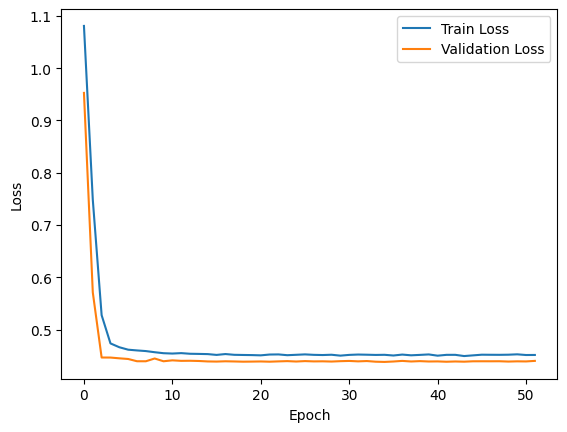

In [134]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [135]:
# 테스트 데이터로 예측
with torch.no_grad():
    model.eval()
    test_inputs = torch.tensor(test_x.values, dtype=torch.float32)
    # test_inputs를 모델이 사용하는 디바이스로 옮기기
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs)

# 예측 결과 출력
print(predictions)

tensor([[3.7089],
        [3.5707],
        [4.5509],
        ...,
        [4.1777],
        [4.3299],
        [4.3054]], device='cuda:0')


In [136]:
# CUDA(GPU)에서 CPU로 텐서 옮기기
predictions_array = predictions.cpu().numpy().flatten()
sample_submission["ECLO"] = predictions_array
sample_submission.to_csv('/content/drive/MyDrive/교통사고/result/submission_토치나난2.csv',index=False)